In [88]:
import numpy as np
import matplotlib.pyplot as plt

from jax import random
from jax import numpy as jnp
from jax.scipy.stats.norm import logcdf as norm_logcdf
from jax.scipy.special import logsumexp
from numpyro.distributions import Uniform
from numpyro import sample, plate, factor
from numpyro.infer import MCMC, NUTS, init_to_median

from corner import corner

%matplotlib inline

In [89]:
def make_data(npoints, m=1, c=0, mu=0, w=1, sigma_x=0.1, sigma_y=0.1,
              sigma_int=0.2, ymax=None, seed=None):
    gen = np.random.default_rng(seed)

    x_true = gen.normal(mu, w, npoints)
    x_obs = gen.normal(x_true, sigma_x)

    y_pred = m * x_true + c
    y_obs = gen.normal(y_pred, np.sqrt(sigma_y**2 + sigma_int**2))

    if ymax is not None:
        mask = y_obs < ymax
        x_obs = x_obs[mask]
        y_obs = y_obs[mask]
        npoints = len(x_obs)

    e_x = np.full(npoints, sigma_x)
    e_y = np.full(npoints, sigma_y)

    return x_obs, y_obs, e_x, e_y


def logmeanexp(a, axis=None, keepdims=False):
    n = a.shape[axis] if axis is not None else a.size
    return logsumexp(a, axis=axis, keepdims=keepdims) - jnp.log(n)

In [116]:
class TruncatedYLineFit:
    """
    MNR-like model with a Gaussian intrinsic scatter and a Gaussian hyperprior
    on the true x values, including an upper truncation in the observed y
    values.
    """

    def __init__(self, x_obs, y_obs, sigma_x, sigma_y, ymax=None):
        if ymax is not None:
            assert np.all(y_obs <= ymax)

        self.x_obs = jnp.asarray(x_obs)
        self.y_obs = jnp.asarray(y_obs)

        self.sigma_x = jnp.asarray(sigma_x)
        self.sigma_y = jnp.asarray(sigma_y)
        self.sx2 = self.sigma_x**2
        self.sy2 = self.sigma_y**2

        self.x_obs_min = jnp.min(self.x_obs)
        self.x_obs_max = jnp.max(self.x_obs)
        self.x_obs_width = self.x_obs_max - self.x_obs_min

        self.ndata = len(self.x_obs)
        self.ymax = ymax

    def log_ll(self, m, c, sigma_int, mu, w):
        """
        Log-likelihood of x_obs and y_obs, marginalised over true x and true y.
        """
        si2 = sigma_int**2
        w2 = w**2

        num = (
            w2 * self.y_obs**2
            + mu**2 * si2
            + (self.y_obs - m * mu)**2 * self.sx2
            + c**2 * (w2 + self.sx2)
            - 2 * c * (w2 * self.y_obs + (self.y_obs - m * mu) * self.sx2)
            + mu**2 * self.sy2
            + self.x_obs * (
                2 * m * w2 * (c - self.y_obs)
                - 2 * mu * (si2 + self.sy2)
                + (m**2 * w2 + si2 + self.sy2) * self.x_obs
            )
        )

        denom = self.sx2 * (si2 + self.sy2) + w2 * (si2 + m**2 * self.sx2 + self.sy2)

        t1 = -2 * jnp.log(jnp.pi * w * self.sigma_x)
        t2 = -jnp.log(4 * (m**2 + (w2 + self.sx2) * (si2 + self.sy2) / (w2 * self.sx2)))

        return 0.5 * (t1 + t2) - 0.5 * num / denom
    
    def log_psel(self, m, c, sigma_int, mu, w):
        mean = m * mu + c
        sigma = jnp.sqrt(m**2 * w**2 + sigma_int**2 + self.sy2)
        return logmeanexp(norm_logcdf(self.ymax, loc=mean, scale=sigma))

    def __call__(self, m_min=-10, m_max=10, c_min=-10, c_max=10,
                 sigma_int_min=1e-3, sigma_int_max=1.0):
        mu = sample("mu", Uniform(self.x_obs_min - 0.5 * self.x_obs_width, self.x_obs_max + 0.5 * self.x_obs_width))
        w = sample("w", Uniform(1e-5, self.x_obs_width))
        factor("log_density_w", -jnp.log(w))

        sigma_int = sample("sigma_int", Uniform(sigma_int_min, sigma_int_max))
        factor("log_density_sigma_int", -jnp.log(sigma_int))

        m = sample("m", Uniform(m_min, m_max))
        c = sample("c", Uniform(c_min, c_max))

        if self.ymax is not None:
            log_psel = self.log_psel(m, c, sigma_int, mu, w)
        else:
            log_psel = 0.0

        with plate("data", self.ndata):
            factor(
                "log_likelihood",
                self.log_ll(m, c, sigma_int, mu, w) - log_psel)



In [148]:
truths = dict(m=1, c=0.5, mu=1, w=1, sigma_x=0.15, sigma_y=0.1, sigma_int=0.2, ymax=1.0)
npoints = 1000

ymax = truths.get("ymax", None)
xobs, yobs, ex, ey = make_data(npoints, **truths, seed=49)

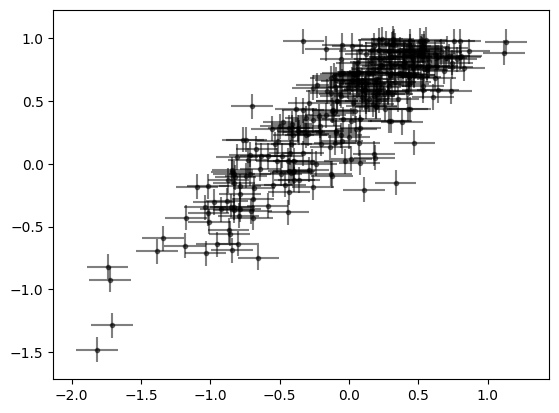

In [149]:
plt.figure()
plt.errorbar(xobs, yobs, xerr=ex, yerr=ey, fmt=".k", alpha=0.5)

plt.show()

In [152]:
model = TruncatedYLineFit(xobs, yobs, ex, ey, ymax=ymax)

kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel, num_warmup=500, num_samples=5000)
mcmc.run(random.PRNGKey(0))

mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 5500/5500 [00:02<00:00, 2075.71it/s, 31 steps of size 1.21e-01. acc. prob=0.94]


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          c      0.50      0.02      0.50      0.47      0.53   2797.59      1.00
          m      0.97      0.03      0.96      0.91      1.02   2239.47      1.00
         mu      1.11      0.47      1.02      0.43      1.85    994.99      1.00
  sigma_int      0.20      0.02      0.20      0.17      0.22   2075.26      1.00
          w      0.95      0.14      0.93      0.74      1.20   1099.82      1.00

Number of divergences: 0


/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_82293/1631254627.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


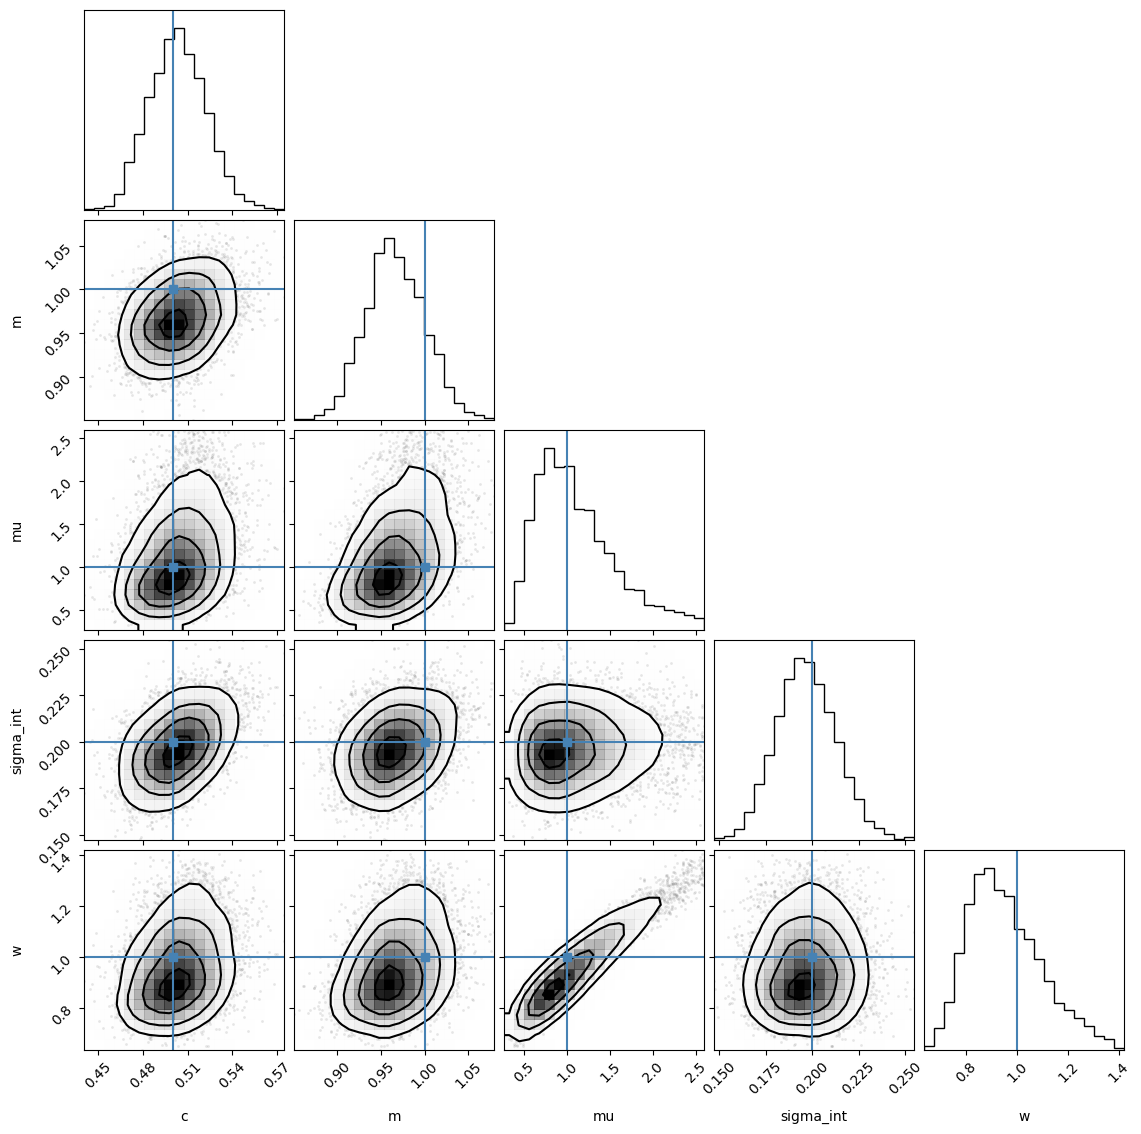

In [153]:
X = np.vstack([samples[k] for k in samples.keys()]).T
labels = list(samples.keys())

fig = corner(X, labels=labels, truths=[truths[k] for k in labels], smooth=1)
fig.show()